In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [100]:
# Load the dataset take that form the kaggle ( NARAYAN YADAV · Updated 4 years ago)
df = pd.read_csv('fraud_call.csv')

df.rename(columns={'lable': 'label', 'discription': 'description'}, inplace=True)

# Display the first few rows
df.head()


,label,description
0,fraud,Todays Vodafone numbers ending with 4882 are s...
1,normal,Please don't say like that. Hi hi hi
2,normal,Thank you!
3,normal,Oh that was a forwarded message. I thought you...
4,normal,Got it. Seventeen pounds for seven hundred ml ...


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5214 entries, 0 to 5213
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        5214 non-null   object
 1   description  5209 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB


In [102]:
df.describe()

,label,description
count,5214,5209
unique,2,4667
top,normal,Sorry
freq,4654,42


In [103]:
df.isnull().sum()

,0
label,0
description,5


In [104]:
# Check how many NaNs are there
print("Missing descriptions:", df['description'].isnull().sum())

# Drop rows with missing label or description
df = df.dropna(subset=['label', 'description'])

# Recheck for any remaining NaNs
print("After handling missing value")
print(df.isnull().sum())

# Proceed with TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(df['description'])

# Target
y = df['label']


Missing descriptions: 5
After handling missing value
label          0
description    0
dtype: int64


/tmp/ipython-input-105-945807436.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


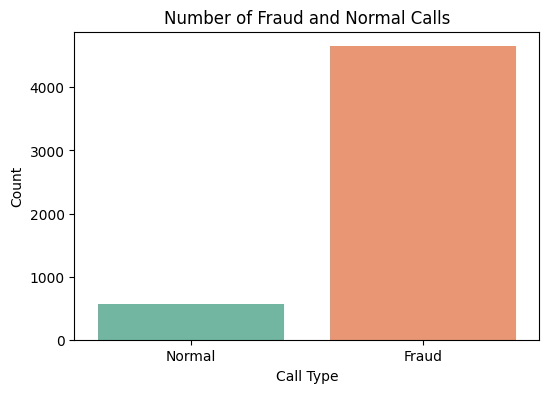

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of fraud and normal calls
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', palette='Set2')
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.title("Number of Fraud and Normal Calls")
plt.xlabel("Call Type")
plt.ylabel("Count")
plt.show()

In [106]:
# Encode labels (fraud = 1, normal = 0)
df['label'] = df['label'].map({'fraud': 1, 'normal': 0})

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(df['description'])

# Target
y = df['label']


In [107]:
# Check how many fraud entries exist and are valid
print("Total fraud entries:", df[df['label'] == 1].shape[0])
print("Non-empty fraud descriptions:", df[(df['label'] == 1) & (df['description'].str.strip() != '')].shape[0])


Total fraud entries: 560
Non-empty fraud descriptions: 560


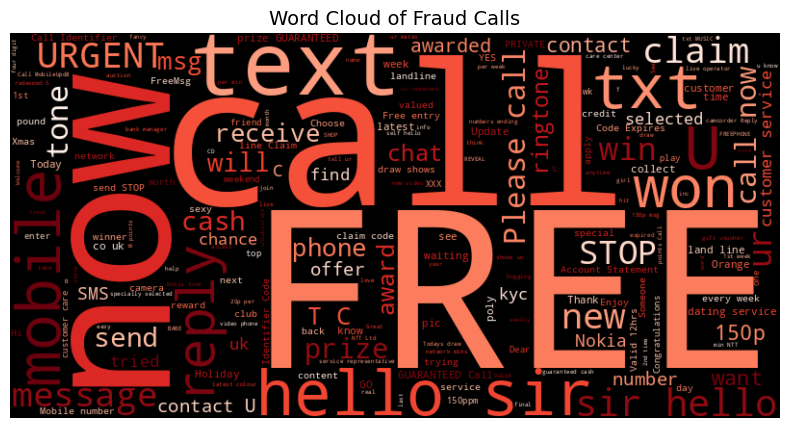

In [108]:
from wordcloud import WordCloud

fraud_text = " ".join(df[df['label'] == 1]['description'])

wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(fraud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Fraud Calls", fontsize=14)
plt.show()


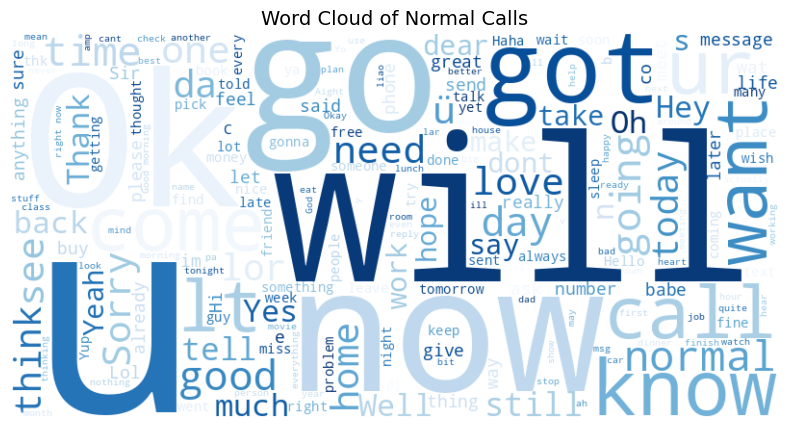

In [109]:
normal_text = " ".join(df[df['label'] == 0]['description'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(normal_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Normal Calls", fontsize=14)
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-110-1652395323.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Reds_r')


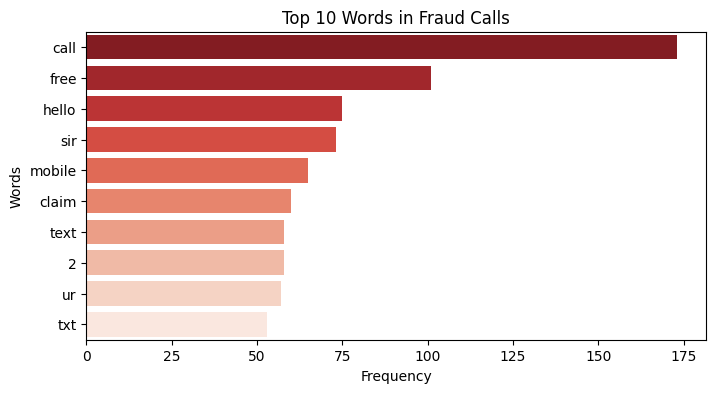

In [110]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Ensure stopwords are downloaded
nltk.download('stopwords')

# Basic tokenization and cleanup
fraud_words = " ".join(df[df['label'] == 1]['description']).lower()
fraud_tokens = [word for word in fraud_words.split() if word not in stopwords.words('english') and word not in string.punctuation]

# Count top 10 words
word_freq = Counter(fraud_tokens).most_common(10)
words, counts = zip(*word_freq)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=list(counts), y=list(words), palette='Reds_r')
plt.title("Top 10 Words in Fraud Calls")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


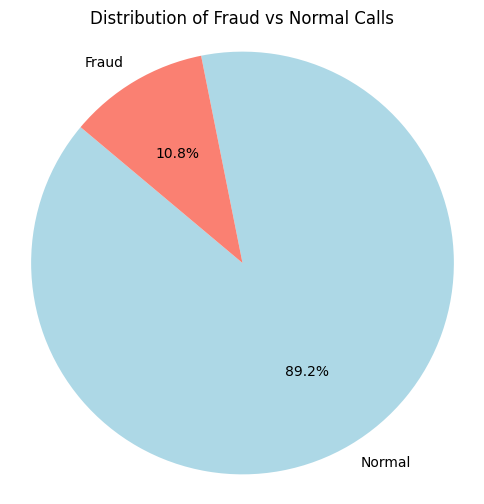

In [111]:
labels = ['Normal', 'Fraud']
sizes = df['label'].value_counts().values
colors = ['lightblue', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Fraud vs Normal Calls")
plt.axis('equal')
plt.show()


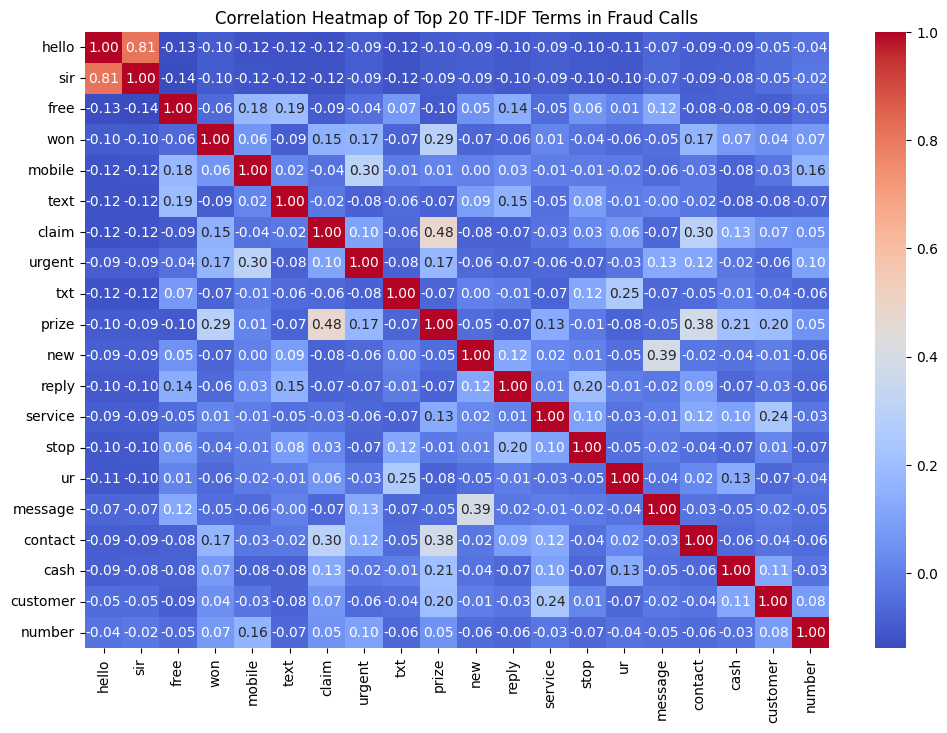

In [112]:
# Get top 20 features based on TF-IDF importance in fraud calls
import numpy as np

fraud_X = vectorizer.transform(df[df['label'] == 1]['description'])
fraud_mean_tfidf = np.asarray(fraud_X.mean(axis=0)).flatten()
top_indices = fraud_mean_tfidf.argsort()[-20:][::-1]
top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
top_df = pd.DataFrame(fraud_X[:, top_indices].toarray(), columns=top_words)

# Correlation plot
plt.figure(figsize=(12, 8))
sns.heatmap(top_df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Top 20 TF-IDF Terms in Fraud Calls")
plt.show()


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_accuracies = []
test_accuracies = []
n_estimators_range = range(10, 210, 10)

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

✅ Model Accuracy: 97.22%

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       941
           1       0.97      0.73      0.84       101

    accuracy                           0.97      1042
   macro avg       0.97      0.87      0.91      1042
weighted avg       0.97      0.97      0.97      1042

Confusion Matrix:
 [[939   2]
 [ 27  74]]


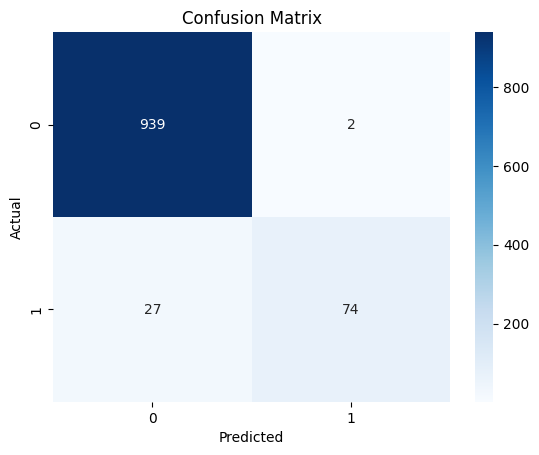

In [115]:
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


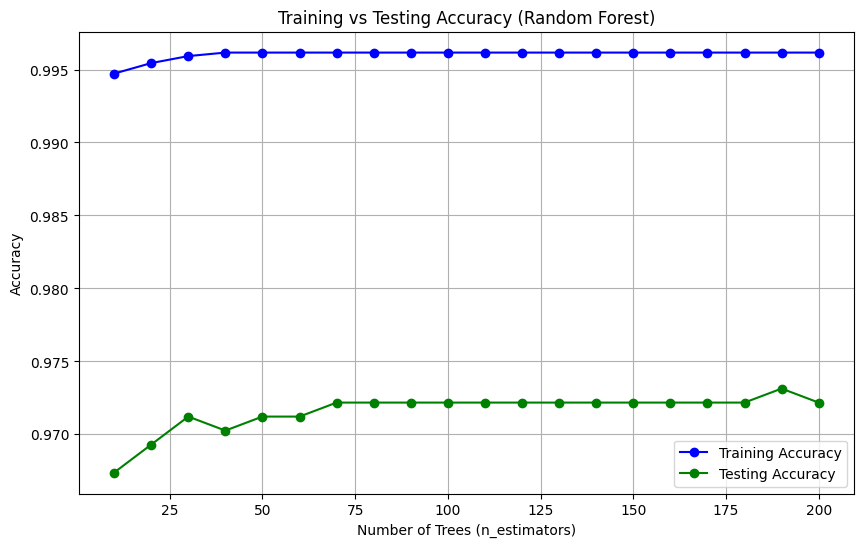

In [116]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, marker='o', label='Training Accuracy', color='blue')
plt.plot(n_estimators_range, test_accuracies, marker='o', label='Testing Accuracy', color='green')
plt.title("Training vs Testing Accuracy (Random Forest)")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [117]:
!pip install xgboost

In [118]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

✅ XGBoost Model Accuracy: 96.35%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       941
       Fraud       0.91      0.69      0.79       101

    accuracy                           0.96      1042
   macro avg       0.94      0.84      0.88      1042
weighted avg       0.96      0.96      0.96      1042



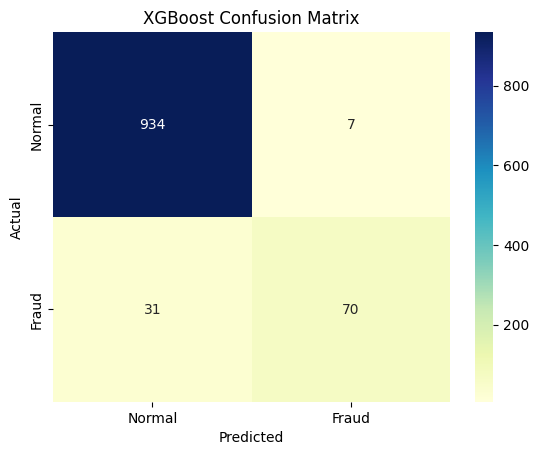

In [119]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Model Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:53] WARNING: /w

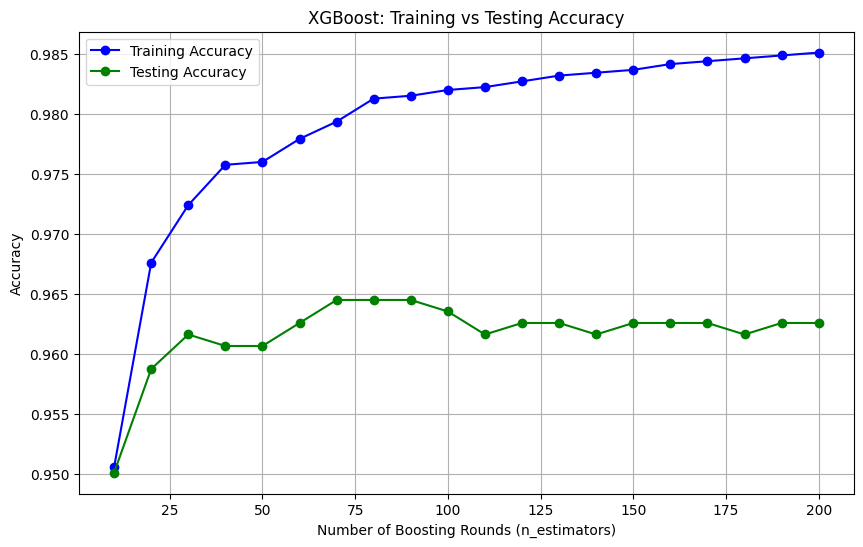

In [120]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Store accuracies
train_accuracies = []
test_accuracies = []

# Range of boosting rounds
round_range = range(10, 210, 10)

for n_rounds in round_range:
    model = xgb.XGBClassifier(n_estimators=n_rounds, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Accuracies
    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

# 📈 Plotting
plt.figure(figsize=(10, 6))
plt.plot(round_range, train_accuracies, marker='o', label='Training Accuracy', color='blue')
plt.plot(round_range, test_accuracies, marker='o', label='Testing Accuracy', color='green')
plt.title("XGBoost: Training vs Testing Accuracy")
plt.xlabel("Number of Boosting Rounds (n_estimators)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


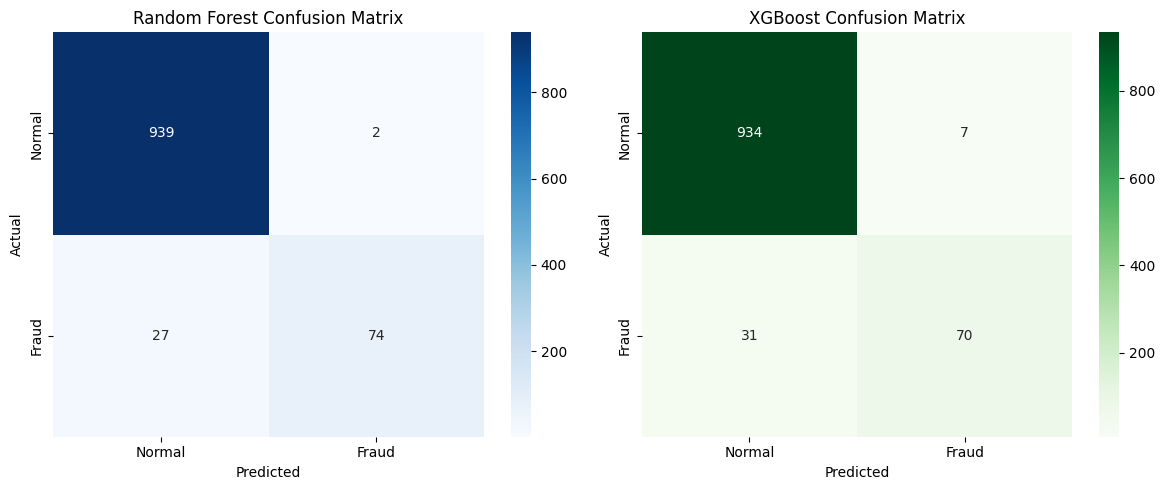

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'model' in cell al9RU8EnCVCI is the trained Random Forest model
# and 'model' in cell EfJn1bbBMYGT is the trained XGBoost model

# Generate predictions for Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42) # Using the best n_estimators from the plot
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Use the existing y_pred for XGBoost (from cell czTsBT3fMakQ)
xgb_preds = y_pred


# Random Forest Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# XGBoost Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [122]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for Random Forest
rf_acc = accuracy_score(y_test, rf_preds)

# Calculate accuracy for XGBoost
xgb_acc = accuracy_score(y_test, xgb_preds)

print("\n📋 Summary Comparison")
print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")
print(f"XGBoost Accuracy      : {xgb_acc * 100:.2f}%")


📋 Summary Comparison
Random Forest Accuracy: 97.22%
XGBoost Accuracy      : 96.35%


In [123]:
!pip install gradio

In [124]:
import matplotlib.pyplot as plt
import numpy as np

def predict_call_fraud_rf(description):
    if not description.strip():
        return "❗ Please enter a valid call description.", None

    # Vectorize
    vector_input = vectorizer.transform([description])

    # Predict class and probability
    pred_class = rf_model.predict(vector_input)[0]
    prob = rf_model.predict_proba(vector_input)[0]  # [prob_normal, prob_fraud]

    # Prepare label
    label = "🚫 Fraud Call" if pred_class == 1 else "✅ Normal Call"

    # Pie chart for confidence
    fig, ax = plt.subplots()
    ax.pie(prob, labels=["Normal", "Fraud"], autopct='%1.1f%%', startangle=90, colors=["#66bb6a", "#ef5350"])
    ax.axis('equal')
    plt.title("Prediction Confidence")

    return label, fig


In [125]:
import gradio as gr

interface = gr.Interface(
    fn=predict_call_fraud_rf,
    inputs=gr.Textbox(lines=3, label="📥 Enter Call Description"),
    outputs=[
        gr.Textbox(label="🔍 Prediction"),
        gr.Plot(label="📊 Confidence Visualization")
    ],
    title="📞 Call Fraud Detection (Random Forest)",
    description="🚨 Enter a phone call description and see whether it's Fraud or Normal — along with prediction confidence!",
    theme="default",
    examples=[
        ["You have won a lottery! Call this number to claim your prize."],
        ["Your SIM card verification is pending. Please call us back."],
        ["Hello, your order has been shipped successfully."]
    ]
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7d2ed00ee77f7b5aa1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
